# Training

### Start sagemaker session

In [72]:
import sagemaker
import os

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

### Define training and validation data path

In [73]:
s3_path = 's3://'
bucket = 'plansoft-sagemaker-mask-detect'
prefix = ''
training_data_directory = 'data/training'
validation_data_directory = 'data/test'

### Setup metric definition

In [69]:
metric_definitions=[
    {'Name': 'train:losses', 'Regex': 'Train_losses=(.*?);'},
    {'Name': 'validation:losses', 'Regex': 'Valid_losses=(.*?);'}
]

### Setup estimator

In [74]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point='train.py',
                role=role,
                framework_version='1.6.0',
                train_instance_count=1,
                train_instance_type='ml.g4dn.2xlarge',
                metric_definitions=metric_definitions,
                hyperparameters={
                    'epochs': 15
                })

### Run fit

In [75]:
training_inputs = os.path.join(s3_path, bucket, prefix, training_data_directory)
validation_inputs = os.path.join(s3_path, bucket, prefix, validation_data_directory)

estimator.fit({'training': training_inputs, 'test':validation_inputs})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-21 14:05:55 Starting - Starting the training job...
2020-10-21 14:05:57 Starting - Launching requested ML instances......
2020-10-21 14:07:16 Starting - Preparing the instances for training......
2020-10-21 14:08:09 Downloading - Downloading input data...
2020-10-21 14:08:42 Training - Downloading the training image........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-10-21 14:10:03,220 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2020-10-21 14:10:03,238 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-10-21 14:10:06,278 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-10-21 14:10:06,648 sagemaker-training-toolkit INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "test": "/opt/ml/input/data/test",
        "trai

# Prediction

In [72]:
from sagemaker.predictor import RealTimePredictor, json_serializer, json_deserializer

class JSONPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(JSONPredictor, self).__init__(endpoint_name, sagemaker_session, json_serializer, json_deserializer)

In [81]:
from sagemaker.pytorch import PyTorchModel

training_job_name = estimator.latest_training_job.name
desc = sagemaker_session.sagemaker_client.describe_training_job(TrainingJobName=training_job_name)
trained_model_location = desc['ModelArtifacts']['S3ModelArtifacts']
model = PyTorchModel(model_data=trained_model_location,
                     role=role,
                     framework_version='1.6.0',
                     entry_point='generate.py',
                     predictor_cls=JSONPredictor)

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [82]:
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-------------------!

In [83]:
input = {
    'url': 'https://i.insider.com/5e71267bc4854010b62f5925?width=1100&format=jpeg&auto=webp'
}
response = predictor.predict(input)
print(response)

[{'boxes': [[827.5440673828125, 488.5679626464844, 949.266357421875, 620.476806640625], [597.8165893554688, 336.0910949707031, 760.23046875, 515.23681640625], [427.6578369140625, 297.16375732421875, 542.0577392578125, 421.84088134765625], [146.64627075195312, 397.7618103027344, 174.2672882080078, 425.0754699707031], [220.1572723388672, 358.41400146484375, 249.1533966064453, 388.0392150878906], [220.26510620117188, 358.4120178222656, 249.92323303222656, 390.47210693359375]], 'labels': [1, 1, 1, 2, 2, 1], 'scores': [0.9993457198143005, 0.998885452747345, 0.9976509213447571, 0.9973971843719482, 0.9727338552474976, 0.13472110033035278]}]


In [110]:
sagemaker_session.delete_endpoint(predictor.endpoint)

## Test model

In [99]:
import matplotlib.pyplot as plt
from matplotlib import patches
import json
from PIL import Image
import requests

def show_prediction(json_out, image_url):
    json_contents = json_out #json.loads(json_out[0])
    image_data = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")

    fig,ax = plt.subplots(1, figsize=(10,10))
    ax.imshow(image_data)

    json_content = json_contents[0]

    for box, score, label in zip(json_content["boxes"], json_content["scores"], json_content["labels"]):
        lab_to_color = {
            1:(0,1,0),
            2:(1,0,0)
        }
        
        xmin, ymin, xmax, ymax = box
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),
                                linewidth=1,
                                edgecolor=lab_to_color[int(label)],
                                facecolor=lab_to_color[int(label)]+(0.2,))
        ax.add_patch(rect)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

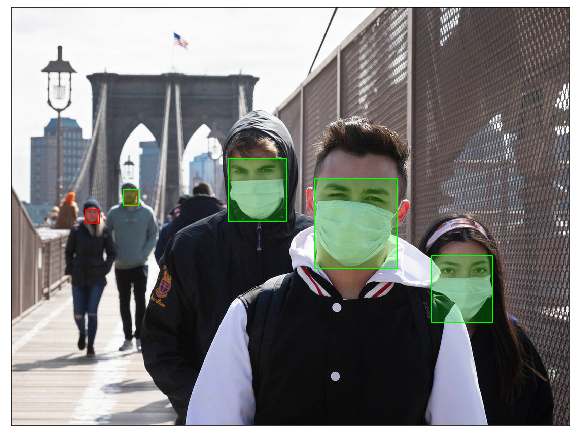

In [100]:
url = 'https://i.insider.com/5e71267bc4854010b62f5925?width=1100&format=jpeg&auto=webp'
input = {'url': url}
response = predictor.predict(input)
show_prediction(response, url)

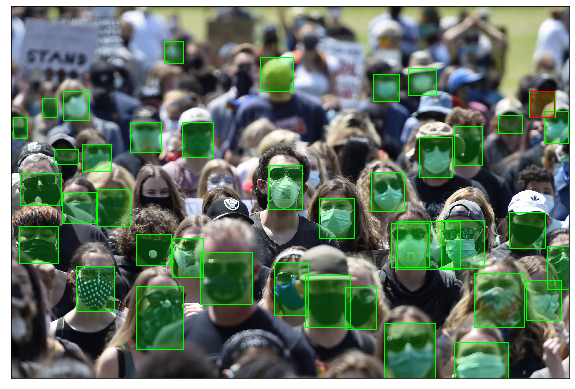

In [101]:
url = 'https://www.mercurynews.com/wp-content/uploads/2020/06/EBT-L-FRIPROTEST-0606-7.jpg'
response = predictor.predict({'url': url})
show_prediction(response, url)

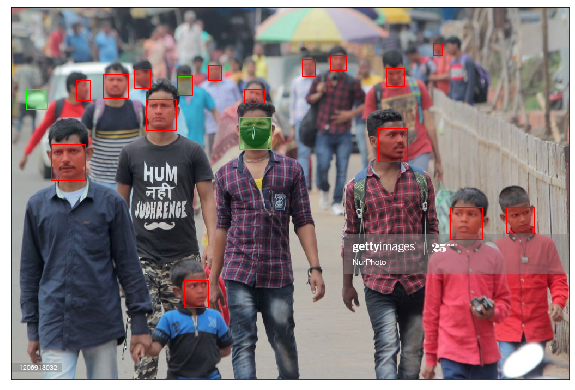

In [103]:
url = 'https://media.gettyimages.com/photos/people-wear-protective-mask-to-fight-against-the-coronavirus-as-they-picture-id1206913032'
response = predictor.predict({'url': url})
show_prediction(response, url)

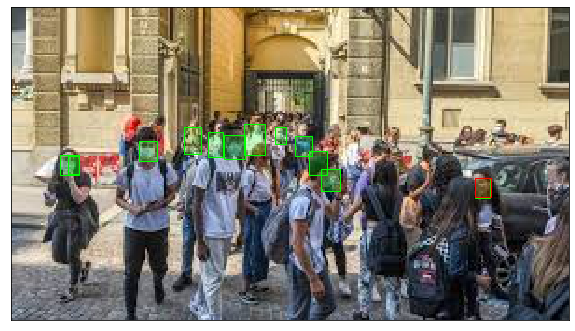

In [109]:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcS06jJeWqY4yxHZ25BlrdCwwPZmgItLXHD8Qg&usqp=CAU'
response = predictor.predict({'url': url})
show_prediction(response, url)